# Plot and extract UNIONS tiles that overlap with spectroscopic surveys

In [1]:
import os
import sys
import re
import numpy as np
import pylab as plt
from astropy.io import fits
import cfis
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
import pandas as pd

import skymapper as skm

plt.ioff()

## Spectroscopic surveys

### Data directory
The catalogs need to be downloaded from the following URLs beforehand.
The 3DHST survey requires registration before tha data can be accessed.

In [2]:
# Download spectroscopic data:
# - 3DHST (AEGIS and GOODS-N)
#   http://monoceros.astro.yale.edu/RELEASE_V4.1.5/3dhst.v4.1.5.master.fits.gz
#   (Need to first register at https://3dhst.research.yale.edu/signup.php)
# - DEEP2, DEEP3:
#   deep.ps.uci.edu/deep3/zcat_archive/alldeep.egs.uniq.2012jun13.fits.gz
# - SDSS
#   - BOSS CMASS + LOWZ DR12:
#     https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_North.fits.gz
#     https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz
# - eBOSS:
#   - LRG DR14
#     https://data.sdss.org/sas/dr14/eboss/lss/catalogs/data_DR14_LRG_N.fits
#     https://data.sdss.org/sas/dr14/eboss/lss/catalogs/data_DR14_LRG_S.fits
#   - LRG + CMASS DR16
#     https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/eBOSS_LRGpCMASS_clustering_data-NGC-vDR16.fits
#     https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/eBOSS_LRGpCMASS_clustering_data-SGC-vDR16.fits
#   - ELG DR 16
#     https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/eBOSS_ELG_clustering_data-NGC-vDR16.fits
#     https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/eBOSS_ELG_clustering_data-SGC-vDR16.fits
# - SDSS value-added main sample
#   http://sdss.physics.nyu.edu/vagc/#download
# - AGES:
#   http://vizier.cfa.harvard.edu/viz-bin/VizieR-3?-source=J/ApJS/200/8/sources

# Download directory
cat_home = '{}/astro/data/CFIS/spectro_surveys'.format(os.environ['HOME'])

### Spectroscopic survey information

In [3]:
class Survey(object):
    """Survey
    Data and information for a spectroscopic survey.
    
    Parameters
    ----------
    name : string
        survey name
    color : string
        plot color
    dec_min : float, optional, default=30
        minimum declination, data with dec<dec_min is cut, in degrees
    dec_max : float, optional, default=90
        maximum declination, data with dec>dec_max is cut, in degrees
    wrap_ra : float, optional, default=None
        use wrap_ra instead of 0 to compute min and max of ra, in degrees;
        useful if ra coordinates wrap around 0. 
    """

    def __init__(self, name, color, dec_min=30, dec_max=90, wrap_ra=None):
        
        self.name = name
        self.color = color
        self.dec_min = dec_min
        self.dec_max = dec_max
        self._wrap_ra = wrap_ra
        
    @classmethod
    def from_fits(cls, name, color, path, key_ra='ra', key_dec='dec', dec_min=30, dec_max=90, wrap_ra=0):
        """Get coordinates from FITS file
        """
        
        dat = fits.open(path)
        ra = dat[1].data[key_ra]
        dec = dat[1].data[key_dec]
        
        c = cls(name, color, dec_min=dec_min, dec_max=dec_max, wrap_ra=wrap_ra)
        c.set_coords(ra, dec)
        return c
    
    @classmethod
    def from_array(cls, name, color, ra, dec, dec_min=30, dec_max=90, wrap_ra=0):
        """Get coordinates from arrays
        """
        
        c = cls(name, color, dec_min=dec_min, dec_max=dec_max, wrap_ra=wrap_ra)
        c.set_coords(np.array(ra), np.array(dec))
        return c

    def set_coords(self, ra, dec):
        """Set coordinates with cuts (UNIONS footprint)
        """  
        
        # Cut area
        idx1 = (self.dec_min < dec)
        idx2 = (dec < self.dec_max)
        idx = idx1 & idx2
        
        n_tot = len(dec)
        n_UNIONS = len(dec[idx])
        print('{}: {} objects in total, {}/{} = {:.1f}% '
              'potentially in UNIONS footprint'
              ''.format(self.name, n_tot, n_UNIONS, n_tot, n_UNIONS/n_tot*100))
        
        if self._wrap_ra:
            self._ra = (ra[idx] + self._wrap_ra)  % 360 - self._wrap_ra + 360
        else:
            self._ra = ra[idx]
        self._dec = dec[idx]
        
        if len(self._ra) > 0:
            self._min_ra = min(self._ra)
            self._max_ra = max(self._ra)
            self._min_dec = min(self._dec)
            self._max_dec = max(self._dec)

### Load the spectroscopic survey data
Define the survey specifications, including name, plot color, and coordinate cuts.

Note: For surveys that extend across the R.A.=0 meridian, use the optional argument `wrap_ra=X` and chose `X` (in degrees) accordingly, such that the data split in R.A. is at `X`.

In [4]:
surveys = []

#use = ['Test', '3DHST-AEGIS', '3DHST-GOODS-N', 'DEEP2+3', 'AGES',
#       'HectoMap-groups', 'DECaLS-groups']

#use = ['CMASSLOWZ12-N', 'CMASSLOWZ12-S', 'eBOSSLRG14-N', 'eBOSSLRG14-S', 'NYUVAGC-N', 
#       'eBOSSLRGCMASS16-N', 'eBOSSLRGCMASS16-S', 'eBOSSELG16-N',
#       'eBOSSQSO16-N', 'eBOSSQSO16-S']

use = ['DEEP2+3']

if 'Test' in use:
    surveys.append(Survey.from_array('Test', 'orange',
                                     [1, 1.1], [29.5, 29.6], dec_min=28))       
if '3DHST-AEGIS' in use:
    surveys.append(Survey.from_fits('3DHST-AEGIS', 'green',
                                    '{}/3dhst.v4.1.5.master.fits'.format(cat_home), 
                                    dec_max=60))
if '3DHST-GOODS-N' in use:
    surveys.append(Survey.from_fits('3DHST-GOODS-N', 'blue',
                                    '{}/3dhst.v4.1.5.master.fits'.format(cat_home), 
                                    dec_min=60))
if 'DEEP2+3' in use:
    surveys.append(Survey.from_fits('DEEP2+3', 'magenta',
                                    '{}/alldeep.egs.uniq.2012jun13.fits'.format(cat_home),
                                    key_ra='RA', key_dec='dec'))
if 'AGES' in use:
    surveys.append(Survey.from_fits('AGES', 'red',
                                    '{}/ages.fits'.format(cat_home),
                                    key_ra='RAJ2000', key_dec='DEJ2000'))
if 'CMASSLOWZ12-N' in use:
    surveys.append(Survey.from_fits('CMASSLOWZ12-N', 'grey',
                                    '{}/galaxy_DR12v5_CMASSLOWZTOT_North.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC'))
if 'CMASSLOWZ12-S' in use:
    surveys.append(Survey.from_fits('CMASSLOWZ12-S', 'grey',
                                    '{}/galaxy_DR12v5_CMASSLOWZTOT_South.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC', wrap_ra=180))
if 'eBOSSLRG14-N' in use:
    surveys.append(Survey.from_fits('eBOSSLRG14-N', 'grey',
                                    '{}/data_DR14_LRG_N.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC'))
if 'eBOSSLRG14-S'in use:
    surveys.append(Survey.from_fits('eBOSSLRG14-S', 'grey',
                                    '{}/data_DR14_LRG_S.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC'))
if 'NYUVAGC-N' in use:
    surveys.append(Survey.from_fits('NYUVAGC-N', 'grey',
                                    '{}/sdss_main_gal.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC', wrap_ra=300))
   
if 'eBOSSLRGCMASS16-N' in use:
   surveys.append(Survey.from_fits('eBOSSLRGCMASS16-N', 'grey',
                                    '{}/eBOSS_LRGpCMASS_clustering_data-NGC-vDR16.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC'))
    
if 'eBOSSLRGCMASS16-S' in use:
   surveys.append(Survey.from_fits('eBOSSLRGCMASS16-S', 'grey',
                                    '{}/eBOSS_LRGpCMASS_clustering_data-SGC-vDR16.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC', wrap_ra=180))    
if 'eBOSSELG16-N' in use:
   surveys.append(Survey.from_fits('eBOSSELG16-N', 'grey',
                                    '{}/eBOSS_ELG_clustering_data-NGC-vDR16.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC'))

# No overlap with CFIS
if 'eBOSSELG16-S' in use:
   surveys.append(Survey.from_fits('eBOSSELG16-S', 'grey',
                                    '{}/eBOSS_ELG_clustering_data-SGC-vDR16.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC', wrap_ra=180))
    
if 'eBOSSQSO16-N' in use:
   surveys.append(Survey.from_fits('eBOSSQSO16-N', 'grey',
                                    '{}/eBOSS_QSO_clustering_data-NGC-vDR16.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC'))
    
if 'eBOSSQSO16-S' in use:
   surveys.append(Survey.from_fits('eBOSSQSO16-S', 'grey',
                                    '{}/eBOSS_QSO_clustering_data-SGC-vDR16.fits'.format(cat_home),
                                    key_ra='RA', key_dec='DEC'))

if 'HectoMap-groups'in use:
    surveys.append(Survey.from_fits('HectoMap-groups', 'cyan',
                                    '{}/asu.fit'.format(cat_home),
                                    key_ra='RAJ2000', key_dec='DEJ2000'))
    
if 'DECaLS-groups'in use:
    surveys.append(Survey.from_fits('DECaLS-groups', 'cyan',
                                    '{}/DESI_NGC_group_cut.txt.fits'.format(cat_home),
                                    key_ra='RA[deg]', key_dec='DEC[deg]'))

DEEP2+3: 23822 objects in total, 23822/23822 = 100.0% potentially in UNIONS footprint


### Compute fraction of matched objects between SDSS sampes

In [9]:
fraction = {}
fraction['N'] = {} # np.zeros(shape=(len(surveys), len(surveys)))
fraction['S'] = {} # np.zeros(shape=(len(surveys), len(surveys)))

tolerance = 1.0 * u.arcsec

for s1 in surveys:
    if len(s1._ra) == 0:
        continue
        
    c1 = SkyCoord(ra=s1._ra, dec=s1._dec, unit='deg')

    for s2 in surveys:
        if len(s2._ra) == 0:
            continue
             
        c2 = SkyCoord(ra=s2._ra, dec=s2._dec, unit='deg')

        idx, d2d, d3d = match_coordinates_sky(c1, c2, nthneighbor=1)

        idx_close = d2d > tolerance
        id_sub = np.where(idx_close==True)[0]
        
        for hemisph in ['N', 'S']:
            if re.search('-{}'.format(hemisph), s1.name) and \
                re.search('-{}'.format(hemisph), s2.name):

                    if s1.name not in fraction[hemisph]:
                        fraction[hemisph][s1.name] = {}
                        
                    fraction[hemisph][s1.name][s2.name] = len(id_sub) / len(idx)
                    
                    print(s1.name, s2.name, end='\t\t')
                    print(' {}/{} = {:.2f}% objects not matched'
                          ''.format(len(id_sub), len(idx), 100*fraction[hemisph][s1.name][s2.name]))

In [10]:
df_N = pd.DataFrame(fraction['N'])
df_N.style.background_gradient(cmap='coolwarm').set_precision(2)

In [11]:
df_S = pd.DataFrame(fraction['S'])
df_S.style.background_gradient(cmap='coolwarm').set_precision(2)

## UNIONS/CFIS data

### Set-up
Define optical bands, paths, and load image IDs.

In [12]:
# Variables
unit = 'deg'
image_type = 'tile'
bands = ['u', 'r', 'i', 'z']
colors = ['b', 'r', 'darkred', 'm']

# Padding around search area in plot
d = 0.5

# Input tiles ID files
sp_home = '{}/astro/repositories/github/shapepipe'.format(os.environ['HOME'])
tiles_dir = '{}/aux/CFIS/tiles_202011'.format(sp_home)
tiles_ID = {}
for band in bands:
    tiles_ID[band] = '{}/tiles_{}.txt'.format(tiles_dir, band)
    
# Output tiles ID file base names
tiles_ID_base = './tile_'
tiles_all_ID_base = '{}{}'.format(tiles_ID_base, ''.join(bands))

# Get list of all images
images = {}
for band in bands:
    images[band] = cfis.get_image_list(tiles_ID[band], band, image_type, input_format='ID_only', verbose=True)

27291 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_u.txt'
12621 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_r.txt'
5363 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_i.txt'
5065 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_z.txt'


## Finding overlapping sky area
For simplicity a rectangular area in R.A. and DEC is determined.

In [14]:
angles = {}
images_overlap = {}
for s in surveys:

    print(s.name)

    # Create area string
    area_str = '{0:.2f}{4}_{1:.2f}{4}_{2:.2f}{4}_{3:.2f}{4}'\
               ''.format(s._min_ra - d,
                         s._min_dec - d,
                         s._max_ra + d,
                         s._max_dec + d,
                         unit)
   
    print(' ', area_str)
    # Get area coordinates from string
    angles[s.name] = cfis.get_Angle_arr(area_str, num=4)
 
    # Get images in selected area
    images_overlap[s.name] = {}
    for band in bands:
        images_overlap[s.name][band] = cfis.find_images_in_area(images[band],
                                                                angles[s.name], band, image_type)
        print(' {} {}-band images in overlap area found'
              ''.format(len(images_overlap[s.name][band]), band))

DEEP2+3
  212.97deg_51.43deg_216.60deg_54.19deg
 0 u-band images in overlap area found
 24 r-band images in overlap area found
 0 i-band images in overlap area found
 0 z-band images in overlap area found


## Identify tile IDs for which some or all multi-band images are present

In [15]:
ID = {}
for s in surveys:
    ID[s.name] = {}
    
    # Get ID strings
    for b in bands:
        ID[s.name][b] = []
        for img in images_overlap[s.name][b]:
            ID[s.name][b].append(img.get_ID())

    # Get common elements by using set intersection
    bands_str = ''
    for b in bands:
        if len(ID[s.name][b]) > 0:
            if not 'all' in ID[s.name]:
                ID[s.name]['all'] = set(ID[s.name][b])
            else:
                ID[s.name]['all'] = ID[s.name]['all'].intersection(ID[s.name][b])

            bands_str = '{}{}'.format(bands_str, b)

print('{}: {} common tiles in {}'.format(s.name, len(ID[s.name]['all']), bands_str))
            
# Write to text files
for s in surveys:
    if len(ID[s.name]['all']) > 0:
        #out_path = '{}_{}.txt'.format(tiles_all_ID_base, s.name)
        out_path = '{}{}_{}.txt'.format(tiles_ID_base, bands_str, s.name)
        f = open(out_path, 'w')
        f.write('\n'.join(ID[s.name]['all']))
        f.write('\n')
        f.close()

DEEP2+3: 24 common tiles in r


## Plotting the sky areas
Create a plot for each spectroscopic survey, showing the spectro objects and UNIONS tiles.

Plotting DEEP2+3...


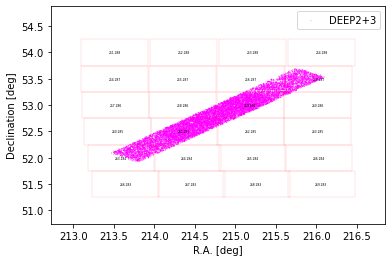

In [16]:
# Max number of spectro objects in plots
n_sp_max = 20000

# If large number of tiles, change plot properties
n_tiles_thres = 100

for s in surveys:

    print('Plotting {}...'.format(s.name))
 
    fig, (ax) = plt.subplots()

    # Plot images
    show_numbers = True
    nimg_tot = 0
    dxy = 0
    for band, color in zip(bands, colors):
        nimg = len(images_overlap[s.name][band])
        nimg_tot = nimg + nimg_tot
        if nimg > n_tiles_thres:
            show_numbers = False
            lw = 0.02
        else:
            lw = 0.1
        if nimg > 0:
            dummy = cfis.plot_area(images_overlap[s.name][band], angles[s.name],
                                   image_type, None, False, col=color,
                                   show_circle=False, show_numbers=show_numbers,
                                   ax=ax, dxy=dxy, lw=lw, save=False)
            if show_numbers:
                show_numbers = False
            dxy = dxy + 0.015

    # Plot spectroscopic objects
    if len(s._ra > n_sp_max):
        idx  = np.random.choice(len(s._ra), n_sp_max)
        ra = s._ra[idx]
        dec = s._dec[idx]
    else:
        ra = s._ra
        dec = s._dec
    
    if nimg_tot > n_tiles_thres:
        plt.rcParams['lines.markersize'] = 0.1
    else:
        plt.rcParams['lines.markersize'] = 1
    ax.scatter(ra, dec, marker='o', color=s.color, edgecolors='none',  alpha=0.5, label=s.name)

    plt.xlabel('R.A. [{}]'.format(unit))
    plt.ylabel('Declination [{}]'.format(unit))
    plt.legend(loc='best')
    plt.savefig('{}.pdf'.format(s.name))
    plt.savefig('{}.png'.format(s.name))
    plt.show()

DEEP2+3


/Users/mkilbing/anaconda3/envs/shapepipe/lib/python3.7/site-packages/skymapper/map.py:198: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
/Users/mkilbing/anaconda3/envs/shapepipe/lib/python3.7/site-packages/skymapper/projection.py:464: RuntimeWarning: invalid value encountered in arcsin
  lat = np.arcsin((self.C - (rho * self.n)**2)/(2*self.n)) / DEG2RAD


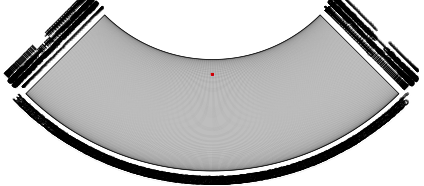

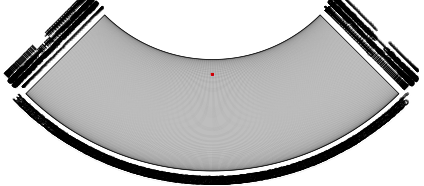

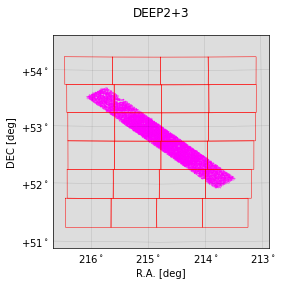

In [162]:
size = cfis.size[image_type] / 2

separation = size * np.sqrt(2) * u.deg

for s in surveys:
    
    print(s.name)
    #fig, (ax) = plt.subplots()
    
    dxy = 0
    ra_all = []
    dec_all = []
    for band, color in zip(bands, colors):
        ra_all.extend([img.ra.degree for img in images_overlap[s.name][band]])
        dec_all.extend([img.dec.degree for img in images_overlap[s.name][band]])

    ra_all = np.array(ra_all)
    dec_all = np.array(dec_all)
    
    # Create map projection
    ## image of (0 0)
    lon_0 = np.mean(ra_all)
    lat_0 = np.mean(dec_all)
    ## the two standard latitudes
    lat_1 = 0
    lat_2 = 30

    ## Projection
    proj = skm.Albers(lon_0, lat_0, lat_1, lat_2)

    ## Create map
    map = skm.Map(proj)
    
    ## Image squares as vertices
    for band, color in zip(bands, colors):
        nimg = len(images_overlap[s.name][band])
        if nimg > 0:
                    
            #vertices = np.zeros(shape=(nimg, 4, 2))
            for i, img in enumerate(images_overlap[s.name][band]):
               
                # Draw lines between image corners
                center = SkyCoord(img.ra, img.dec)
                pos = []
                for position_angle in [45, 135, 225, 315]:
                    pos.append(center.directional_offset_by(position_angle * u.deg, separation))
                pos.append(pos[0])
                cx = np.array([p.ra.deg for p in pos])
                cy = np.array([p.dec.deg for p in pos])
                map.plot(cx, cy, '-', color=color, linewidth=0.5)

            dxy = dxy + 0.015

    # Spectroscopic objects
    ra = s._ra
    dec = s._dec
    map.scatter(ra, dec, marker='o', color=s.color, edgecolors='none',  alpha=0.5)
    
    # Draw grid
    sep = 1
    map.grid(sep=sep)
    
    #map.focus(np.array([213, 217]), np.array([51, 54.5]))
    ra_min_max = ra_all.min(), ra_all.max()
    dec_min_max = dec_all.min(), dec_all.max()

    map.focus(np.array(ra_min_max), np.array(dec_min_max), pad=0.25)

    map.ax.set_xlabel('R.A. [deg]')
    map.ax.set_ylabel('DEC [deg]')
    map.title(s.name)

    map.savefig('{}_spherical.pdf'.format(s.name))
    plt.show()